In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(0)
torch.manual_seed(0)

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)

latent_dims = []
input_dim = 0
hidden_dim = 512
N = 10

for column in hts_df.columns:
    print(f'Attribute Type = {column}')
    print(f'Num of Categories in Attribute = {hts_df[column].nunique()}')
    latent_dims.append([N, hts_df[column].nunique()])
    input_dim += hts_df[column].nunique()

Attribute Type = start_type
Num of Categories in Attribute = 5
Attribute Type = act_num
Num of Categories in Attribute = 9
Attribute Type = mode_num
Num of Categories in Attribute = 9
Attribute Type = end_type
Num of Categories in Attribute = 5


In [3]:
encoder = OneHotEncoder(sparse=False)
one_hot_data = encoder.fit_transform(hts_df.values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loader = DataLoader(one_hot_data, batch_size=250, shuffle=True)

In [4]:
latent_dim = 100
learning_rate_g = 0.0007
learning_rate_d = 0.0004
num_epochs = 25
temperature = 3

def gumbel_softmax(logits, temperature):
    # Apply Gumbel-Softmax
    y = F.gumbel_softmax(logits, tau=temperature, hard=True)
    return y

class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z, temperature=1.0):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        logits = self.fc3(h)
        
        # Apply Gumbel-Softmax to generate categorical outputs
        start = 0
        outputs = []
        for N, K in latent_dims:
            end = start + K
            logits_slice = logits[:, start:end]
            y = gumbel_softmax(logits_slice, temperature)
            outputs.append(y)
            start = end
        return torch.cat(outputs, dim=1)
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h))
    
generator = Generator(latent_dim, hidden_dim, input_dim).to(device)
discriminator = Discriminator(input_dim, hidden_dim).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

scheduler_G = optim.lr_scheduler.ExponentialLR(optimizer_G, gamma=0.97)
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.97)

adversarial_loss = nn.BCELoss()

In [5]:
for epoch in range(num_epochs):
    for i, real_data in enumerate(data_loader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device).float()
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        optimizer_D.zero_grad()
        
        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim).to(device)
        
        # Generate a batch of data
        gen_data = generator(z, temperature)
        
        # Discriminator loss on real and fake data
        real_loss = adversarial_loss(discriminator(real_data), valid)
        fake_loss = adversarial_loss(discriminator(gen_data.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        
        # Generator loss
        g_loss = adversarial_loss(discriminator(gen_data), valid)
        
        g_loss.backward()
        optimizer_G.step()
    
    scheduler_G.step()
    scheduler_D.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")
    
torch.save(generator.state_dict(), 'models/generator_discrete.pth')

Epoch [1/25]  D Loss: 0.3792  G Loss: 1.8999
Epoch [2/25]  D Loss: 0.2631  G Loss: 2.1656
Epoch [3/25]  D Loss: 0.3920  G Loss: 2.1897
Epoch [4/25]  D Loss: 0.3511  G Loss: 1.8319
Epoch [5/25]  D Loss: 0.4496  G Loss: 2.5455
Epoch [6/25]  D Loss: 0.2944  G Loss: 2.5962
Epoch [7/25]  D Loss: 0.3500  G Loss: 2.4522
Epoch [8/25]  D Loss: 0.3532  G Loss: 1.7544
Epoch [9/25]  D Loss: 0.2947  G Loss: 2.6120
Epoch [10/25]  D Loss: 0.3402  G Loss: 2.5323
Epoch [11/25]  D Loss: 0.2763  G Loss: 2.2456
Epoch [12/25]  D Loss: 0.3067  G Loss: 2.7004
Epoch [13/25]  D Loss: 0.2905  G Loss: 2.5796
Epoch [14/25]  D Loss: 0.3529  G Loss: 1.9321
Epoch [15/25]  D Loss: 0.3761  G Loss: 1.6802
Epoch [16/25]  D Loss: 0.4072  G Loss: 1.3720
Epoch [17/25]  D Loss: 0.3592  G Loss: 1.7595
Epoch [18/25]  D Loss: 0.3900  G Loss: 1.5018
Epoch [19/25]  D Loss: 0.3741  G Loss: 1.6438
Epoch [20/25]  D Loss: 0.4176  G Loss: 1.6584
Epoch [21/25]  D Loss: 0.3816  G Loss: 1.5138
Epoch [22/25]  D Loss: 0.4017  G Loss: 1.47

In [6]:
# Number of samples you want to generate
num_samples = 3000

# Latent dimension (same as used during training)
latent_dim = 100  # Ensure this matches your generator's input size

# Temperature parameter for Gumbel-Softmax
temperature = 3  # Adjust as needed; lower values make outputs more discrete

# Generate random noise
z = torch.randn(num_samples, latent_dim).to(device)

# Generate synthetic data
generator.eval()  # Set generator to evaluation mode
with torch.no_grad():
    gen_data = generator(z, temperature)

In [7]:
def softmax_to_one_hot(y_soft):
    """Convert softmax outputs to one-hot encoded vectors."""
    _, max_indices = y_soft.max(dim=1)
    y_hard = torch.zeros_like(y_soft).scatter_(1, max_indices.view(-1, 1), 1)
    return y_hard

# Apply this conversion to each categorical variable in your generated data
start = 0
gen_one_hot = []
for N, K in latent_dims:
    end = start + K
    y_soft = gen_data[:, start:end]
    y_hard = softmax_to_one_hot(y_soft)
    gen_one_hot.append(y_hard)
    start = end

# Concatenate all one-hot encoded variables
gen_one_hot = torch.cat(gen_one_hot, dim=1)

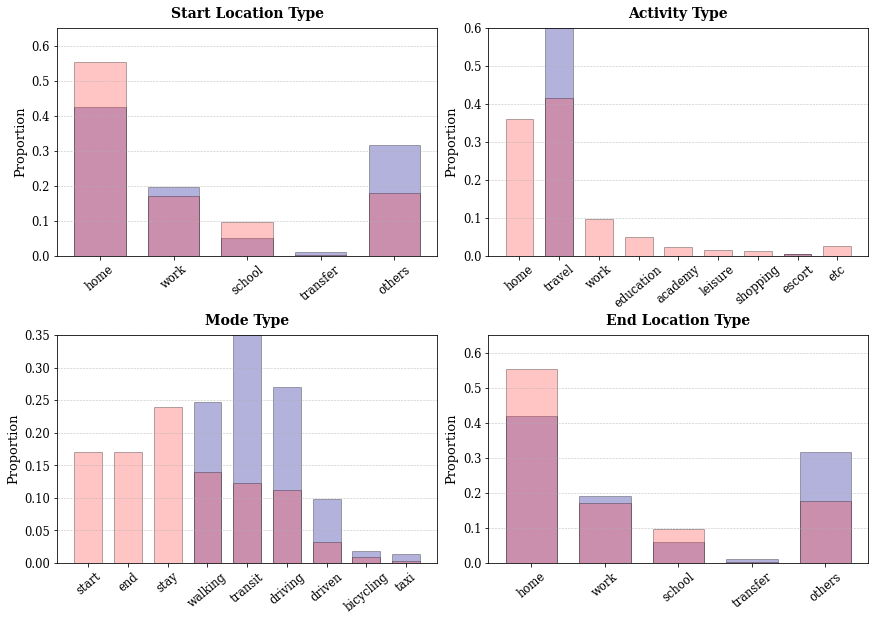

In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(h_pad=6, w_pad=2)

attribute_list = ['start_type', 'act_num', 'mode_num', 'end_type']
title_list = ['Start Location Type', 'Activity Type', 'Mode Type', 'End Location Type']
location_list = ['home', 'work', 'school', 'transfer', 'others']
act_list = ['home', 'travel', 'work', 'education', 'academy', 'leisure', 'shopping', 'escort', 'etc']
mode_list = ['start', 'end', 'stay', 'walking', 'transit', 'driving', 'driven', 'bicycling', 'taxi']
axis_list = [location_list, act_list, mode_list, location_list]
ylim_list = [0.65, 0.6, 0.35, 0.65]

start = 0

for (N, K), name, title, axis, ylim, ax in zip(latent_dims, attribute_list, title_list, axis_list, ylim_list, axs.flatten()):

    end = start + K
    types = np.argmax(gen_one_hot[:, start:end].cpu(), axis=1)
    unique, counts = np.unique(types, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#00008F', edgecolor='black', width=0.7, alpha=0.3)
    
    unique, counts = np.unique(hts_df[name].values, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#FF4040', edgecolor='black', width=0.7, alpha=0.3)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(np.arange(K))
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    ax.set_xticklabels(axis, rotation=40)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.set_ylabel('Proportion', fontsize=13)
    start = end

plt.savefig(f'gan_discrete.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()